In [1]:
import os
import csv

from PIL import Image
import matplotlib.pyplot as plt

from util.visualize import show_pyg_graph
import networkx as nx
from IPython.display import clear_output

from data.action_genome import AG

%load_ext autoreload


In [2]:
root = '/data/Datasets/ag/'
ag = AG(root)

folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/QQ9RN.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/RTULL.mp4 does not exist
folder /data/Datasets/ag/frames/VKLP7.mp4 does not exist
folder /data/Datasets/ag/frames

In [3]:
for a in ag.action_classes:
    print(a)

c000 Holding some clothes
c001 Putting clothes somewhere
c002 Taking some clothes from somewhere
c003 Throwing clothes somewhere
c004 Tidying some clothes
c005 Washing some clothes
c006 Closing a door
c007 Fixing a door
c008 Opening a door
c009 Putting something on a table
c010 Sitting on a table
c011 Sitting at a table
c012 Tidying up a table
c013 Washing a table
c014 Working at a table
c015 Holding a phone/camera
c016 Playing with a phone/camera
c017 Putting a phone/camera somewhere
c018 Taking a phone/camera from somewhere
c019 Talking on a phone/camera
c020 Holding a bag
c021 Opening a bag
c022 Putting a bag somewhere
c023 Taking a bag from somewhere
c024 Throwing a bag somewhere
c025 Closing a book
c026 Holding a book
c027 Opening a book
c028 Putting a book somewhere
c029 Smiling at a book
c030 Taking a book from somewhere
c031 Throwing a book somewhere
c032 Watching/Reading/Looking at a book
c033 Holding a towel/s
c034 Putting a towel/s somewhere
c035 Taking a towel/s from somewh

In [4]:
for b in ag.object_classes:
    print(b)

__background__
person
bag
bed
blanket
book
box
broom
chair
closet/cabinet
clothes
cup/glass/bottle
dish
door
doorknob
doorway
floor
food
groceries
laptop
light
medicine
mirror
paper/notebook
phone/camera
picture
pillow
refrigerator
sandwich
shelf
shoe
sofa/couch
table
television
towel
vacuum
window


In [7]:
print(len(ag))

33432


c127 Tidying something on the floor
JSUF4.mp4/000022.png
Data(x=[3, 37], edge_index=[2, 7], edge_attr=[7, 26], y=[1], node_type=[3], edge_type=[7], id='JSUF4.mp4/000022.png')
[('person', 'looking_at', 'floor'), ('floor', 'beneath', 'person'), ('floor', 'in_front_of', 'person'), ('person', 'standing_on', 'floor'), ('person', 'looking_at', 'broom'), ('broom', 'in_front_of', 'person'), ('person', 'holding', 'broom')]


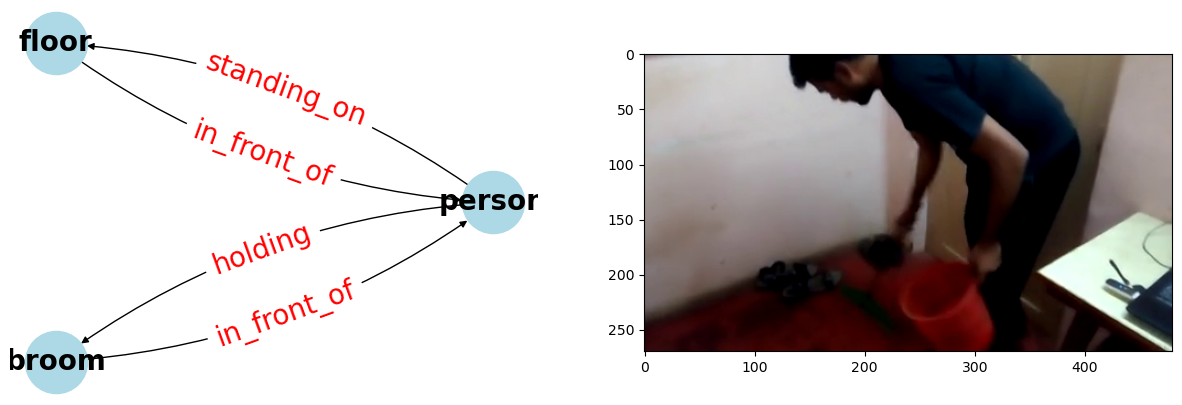

In [ ]:
%autoreload

subset_dict = 

index = 0
while True:

    if index >= len(ag) or index < 0:
        print('out of bounds index, returning to index 0')
        index = 0
        break

    clear_output(wait=True)

    id, img, sg, action = ag[index]
    print('INDEX:', index)
    print(ag.action_classes[action])
    print('ID:', id)
    nodes = [ag.object_classes[t] for t in sg.node_type]
    print([ (nodes[sg.edge_index[0][i].item()], \
            ag.relationship_classes[t], \
            nodes[sg.edge_index[1][i].item()], \
            ) for i,t in enumerate(sg.edge_type)])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    show_pyg_graph(sg, ag.object_classes, ag.relationship_classes, layout='circular', curve=0.1, ax=axs[0])
    axs[1].imshow(img)
    plt.show(fig)

    answer = input('Enter to continue, space to mark invalid, q to quit, b to go back, or type an index to jump to')
    if answer == 'q':
        confirm = input('quitting, enter to continue, space to cancel')
        if confirm == ' ':
            continue
        else:
            break
    elif answer == '':
        if index == len(ag) - 1:
            _ = input('max index reached, enter to continue')
            continue
        index += 1
        continue
    elif answer == 'b':
        if index == 0:
            _ = input('first index reached, enter to continue')
            continue
        index -= 1
        continue
    elif answer == ' ':
        ag.mark_invalid(index)

        if index == len(ag) - 1:
            _ = input('max index reached, enter to continue')
            continue
        index += 1
        continue
    else:
        try: 
            goto_idx = int(answer)
            if goto_idx < 0 or goto_idx >= len(ag):
                _ = input('out of bounds index, enter to continue')
                continue
        except ValueError:
            _ = input('invalid index, enter to continue')
            continue